In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import math
import numpy
from torch.nn.functional import pad
import torch.nn.init as init
import copy
from torch import autograd
from torchvision.utils import make_grid
from torch.optim import Adam
from torch.utils.data import DataLoader,TensorDataset
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import tqdm
import functools
import time

from network_class import *
from utils import *


In [8]:

device = 'cuda:2' #@param ['cuda', 'cpu'] {'type':'string'}

n_epochs =  600#@param {'type':'integer'}
batch_size =  1000 #@param {'type':'integer'}
lr=4e-2 #@param {'type':'number'}
tspan=[0,1]
data_name="moon"  # "moon" "checkerboard" "circles"
d=2
nt=8
h=(tspan[1]-tspan[0])/nt


f_theta = velocity_net(d=2)
f_theta = f_theta.to(device)

print("total parameter is: ", count_parameters(f_theta))
optim = Adam(f_theta.parameters(), lr=lr)




total parameter is:  4416
total parameter is:  None


In [9]:
def log_Gaussian(x,d):
    return -d/2*math.log(2*math.pi)-torch.sum(x**2,dim=1).reshape(-1,1)/2

def grad_log_Gaussian(x):
    return -x

def stepRK4(odefun, z, net,t0, t1):
    h = t1 - t0 # step size
    z0 = z
    K = h * odefun(z0, t0, net)
    z_temp = z0 + (1.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp =z_temp+ (2.0/6.0) * K
    K = h * odefun( z0 + 0.5*K , t0+(h/2) ,net)
    z_temp = z_temp+(2.0/6.0) * K
    K = h * odefun( z0 + K , t0+h ,net)
    z_temp = z_temp+(1.0/6.0) * K
    return z_temp



def stepRK1(odefun, z, net,t0, t1):
    z0 = z
    z_temp =z0 + (t1 - t0) * odefun(z0, t0, net)

    return z_temp

def odefun(x, t, net):
    dx = net(x,t)
    return dx


def odefun_backward(cat_var, t, net):
    x=cat_var[:,0:d]
    score=cat_var[:,d+1:-1]
    


    divergence_f=torch.zeros(x.shape[0],device=device)
    
    f=net(x, t).reshape(x.shape[0],-1)

    jacobian = []
    for i in range(d):
        jacobian_i = autograd.grad(f[:,i].sum(), x, create_graph=True,retain_graph=True)[0]
        # torch.autograd.functional.jacobian
        jacobian.append(jacobian_i)
        # print(jacobian_i[0])
    stacked_jacobbian = torch.stack(jacobian, dim=2)
    # print(stacked_jacobbian[0,:,:])

    
    #精确计算divergence_f
    # for i in range(d):
    #     grad = autograd.grad(f[:,i].sum(), x, create_graph=True)[0]
    #     divergence_f+= grad[:,i]
    divergence_f = torch.diagonal(stacked_jacobbian, dim1=-2, dim2=-1).sum(-1).reshape(-1,1)
    

    # # 近似计算divergence_f
    # v=torch.randn(f.shape).to(device)
    # vf=torch.sum(f*v, dim=1)
    # a=autograd.grad(vf.sum(),x,create_graph=True)[0].reshape(x.shape[0],-1)
    # divergence_f=torch.sum(a*v, dim=1)

    
    d_log=-divergence_f.reshape(-1,1)


    #calculate jacobbian 
    grad_div_f=autograd.grad(divergence_f.sum(), x, create_graph=True,retain_graph=True)[0]
    # stacked_jacobbian_transpose = torch.transpose(stacked_jacobbian, 1, 2)
    J_mul_f=torch.bmm(stacked_jacobbian,score.unsqueeze(2)).squeeze()
    d_score=(-grad_div_f-J_mul_f)
    d_penalty=torch.mean(torch.sum((f+score)**2,dim=1))*torch.ones(x.shape[0],1).to(device)*0.5


    # d_score=torch.zeros(x.shape[0],d).to(device)
    # d_penalty=torch.zeros(x.shape[0],1).to(device)


    return torch.cat((f,d_log,d_score,d_penalty),dim=1)


In [10]:
llh_record=[]
v_pen_record=[]

tqdm_epoch = tqdm.trange(n_epochs)

for epoch in tqdm_epoch:
    
    #resample
    x=torch.tensor(generate_2d(batch_size=batch_size,data_name=data_name)).float().to(device)
         

    z_temp,tk=x,0
    for k in range(nt):
        tk=h*k
        z_temp = stepRK4(odefun, z_temp , f_theta, tk, tk+h)

 


    z_terminal=z_temp
    log_terminal=log_Gaussian(x=z_terminal,d=d)
    log_temp=log_terminal
 
    score_terminal=grad_log_Gaussian(z_terminal)
    score_temp=score_terminal
    

    tk=tspan[1]
    z_back=z_terminal
    cat_var=torch.cat((z_back,log_temp,score_temp),dim=1)
    cat_var=pad(cat_var,(0,1,0,0),value=0)
    
    for k in  range(nt):
        cat_var= stepRK4(odefun_backward, cat_var , f_theta, tk, tk-h)
        tk-=h

    z,log_temp,bridge_pen=cat_var[:,0:d],cat_var[:,d],-cat_var[0,-1]
    nll=torch.mean(log_temp)

    optim.zero_grad()
    loss=-nll*10  + bridge_pen
    loss.backward()
    optim.step()
    llh_record.append(-torch.mean(log_temp).detach().cpu())
    v_pen_record.append(bridge_pen.detach().cpu())
    tqdm_epoch.set_description('nll: {:5f} BP: {:5f}'.format(-torch.mean(log_temp).detach().cpu(),bridge_pen.detach().cpu()))
    torch.save(f_theta.state_dict(), 'experiment/'+data_name+'_2d.pth')
    if (epoch+1) % 100 == 0:
            for p in optim.param_groups:
                p['lr'] /= 2
            print("lr: ", p['lr'])

    if (epoch+1) % 50== 0:
        x=torch.tensor(generate_2d(batch_size=10000,data_name=data_name)).float().to(device)
        zFull = torch.zeros(*x.shape , nt+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt
        zFull[:,:,0] = x

        tk=0
        for k in range(nt):
            tk=h*k
            zFull[:,:,k+1] = stepRK4(odefun, zFull[:,:,k] , f_theta, tk, tk+h)
            z=zFull.detach().cpu().numpy()

        z_forward=zFull.detach().cpu().numpy()
        fig, axs = plt.subplots(1, nt+1, figsize=(18,2.5))
        for i in range(nt+1):
            axs[i].hist2d(z_forward[:,0,i],z_forward[:,1,i],bins=100, range=[[-4, 4], [-4, 4]])
        plt.tight_layout()
        plt.savefig("diagnose_plot/forward.png")
        plt.close()

        x=torch.randn(10000,2).to(device)
        nt_val=24
        h_val=1/nt_val
        zFull_inverse = torch.zeros(*x.shape , nt_val+1, device=x.device, dtype=x.dtype) # make tensor of size z.shape[0], z.shape[1], nt
        zFull_inverse[:,:,0] = x

        for k in range(nt_val):
            tk=1-h_val*k
            zFull_inverse[:,:,k+1] = stepRK4(odefun, zFull_inverse[:,:,k] , f_theta, tk, tk-h_val)


        z_backward=zFull_inverse.detach().cpu().numpy()
        fig, axs = plt.subplots(1, nt+1, figsize=(18,2.5))
        for i in range(nt+1):
            axs[i].hist2d(z_backward[:,0,3*i],z_backward[:,1,3*i],bins=100, range=[[-4, 4], [-4, 4]])
        plt.tight_layout()
        plt.savefig("diagnose_plot/backward.png")
        plt.close()



        plt.figure(figsize=(6, 6))
        for i in range(50):
            plt.plot(z_backward[i,0,:],z_backward[i,1,:],color="white",marker='o', linestyle='-',markersize=3)
        plt.hist2d(z_backward[:,0,-1],z_backward[:,1,-1],bins=100, range=[[-4, 4], [-4, 4]])
        plt.tight_layout()
        plt.savefig("diagnose_plot/trajectories.png")
        plt.close()

    
    
 



nll: 3.081241 BP: 1.618442:  16%|█▋        | 99/600 [01:19<06:33,  1.27it/s]

lr:  0.02


nll: 2.984891 BP: 1.687841:  33%|███▎      | 199/600 [02:41<05:14,  1.27it/s]

lr:  0.01


nll: 2.947502 BP: 1.735160:  50%|████▉     | 299/600 [04:03<04:02,  1.24it/s]

lr:  0.005


nll: 2.919222 BP: 1.858975:  66%|██████▋   | 399/600 [05:26<02:41,  1.24it/s]

lr:  0.0025


nll: 2.925184 BP: 1.690293:  83%|████████▎ | 499/600 [06:49<01:20,  1.26it/s]

lr:  0.00125


nll: 2.935311 BP: 1.672278: 100%|█████████▉| 599/600 [08:09<00:00,  1.25it/s]

lr:  0.000625


nll: 2.935311 BP: 1.672278: 100%|██████████| 600/600 [08:11<00:00,  1.22it/s]


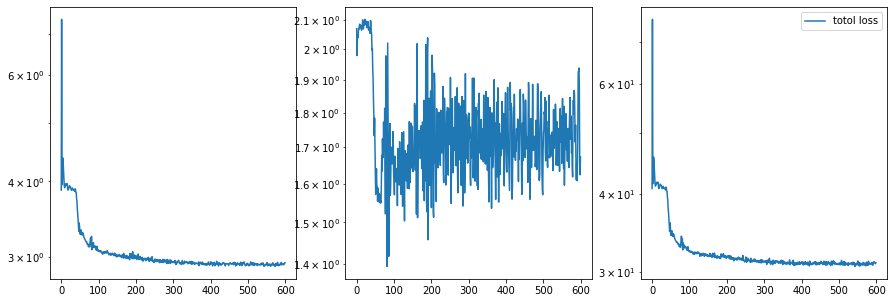

tensor(1.6723)


In [11]:

plot_loss_all(llh_record,v_pen_record)
print(v_pen_record[-1])


In [14]:
x=torch.tensor([3.,3.]).to(device).reshape(1,2)
t=0
print(f_theta(x,t))


tensor([[-2.6980,  1.5501]], device='cuda:2', grad_fn=<MmBackward>)
